# Machine Learning and Topological Data Analysis

Mathieu Carrière, https://mathieucarriere.github.io/website/

In [1]:
import numpy as np
import gudhi as gd
import gudhi.representations
import matplotlib.pyplot as plt

In this notebook, we will see how to efficiently combine machine learning and topological data analysis with the Gudhi library and its [representations](https://gudhi.inria.fr/python/3.1.0.rc1/representations.html) module. We will see how to compute the various Hilbert representations of persistence diagrams and how to use them in order to classify a set of persistence diagrams! Ready? Let's go!

First, we will generate persistence diagrams with orbits of dynamical systems. This dataset is very common in TDA and was introduced in the [persistence image](https://arxiv.org/abs/1507.06217) paper. We use the following system, which depends on a parameter $r>0$:

$$x_{n+1}=x_n+ry_n(1-y_n)\ \ \ \ \text{(mod 1)}$$
$$y_{n+1}=y_n+rx_{n+1}(1-x_{n+1})\ \ \ \ \text{(mod 1)}$$

Let's first see what the point cloud looks like for a given choice of $r$.

In [2]:
num_pts = 1000
r       = 3.5

Here we generate the point cloud.

In [3]:
X = np.empty([num_pts,2])
x, y = np.random.uniform(), np.random.uniform()
for i in range(num_pts):
    X[i,:] = [x, y]
    x = (X[i,0] + r * X[i,1] * (1-X[i,1])) % 1.
    y = (X[i,1] + r * x * (1-x)) % 1.

And now, we visualize it.

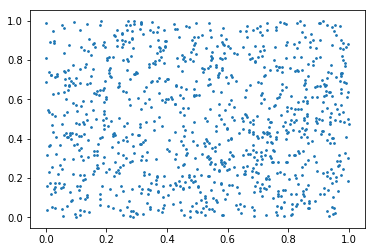

In [4]:
plt.scatter(X[:,0], X[:,1], s=3)
plt.show()

Mmmh, looks like a random point cloud... We will see later on that interesting topology can appear for some specific values of $r$.

An easy way to generate persistence diagrams from this cloud is by using alpha filtrations. This can be done in two lines with Gudhi:

In [5]:
acX = gd.AlphaComplex(points=X).create_simplex_tree()
dgmX = acX.persistence()

We can also easily visualize the persistence diagram: 

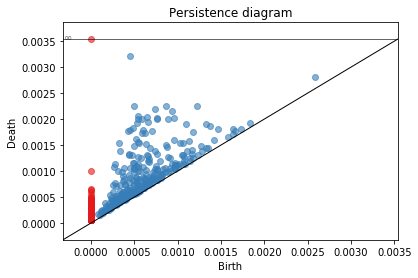

In [6]:
gd.plot_persistence_diagram(dgmX)

Now, let's see what Gudhi has to offer to turn this diagram into a vector in a [scikit-learn](https://scikit-learn.org/stable/) fashion, that is, with estimators that have fit(), transform(), and fit_transform() methods!

The first method that was introduced historically is the [persistence landscape]( http://jmlr.org/papers/v16/bubenik15a.html). A persistence landscape is basically obtained by rotating the persistence diagram by $-\pi/4$ (so that the diagonal becomes the $x$-axis), and then putting tent functions on each point. The $k$th landscape is then defined as the $k$th largest value among all these tent functions. It is eventually turned into a vector by evaluating it on a bunch of uniformly sampled points on the x-axis.

In [7]:
LS = gd.representations.Landscape(resolution=1000)
L = LS.fit_transform([acX.persistence_intervals_in_dimension(1)])

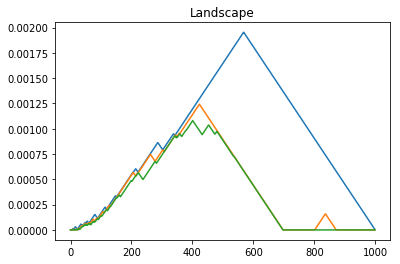

In [8]:
plt.plot(L[0][:1000])
plt.plot(L[0][1000:2000])
plt.plot(L[0][2000:3000])
plt.title("Landscape")
plt.show()

A variation, called the [silhouette](https://arxiv.org/abs/1312.0308), takes a weighted average of these tent functions instead. Here, we weight each tent function by the distance of the corresponding point to the diagonal.

In [9]:
SH = gd.representations.Silhouette(resolution=1000, weight=lambda x: np.power(x[1]-x[0],1))
sh = SH.fit_transform([acX.persistence_intervals_in_dimension(1)])

Text(0.5, 1.0, 'Silhouette')

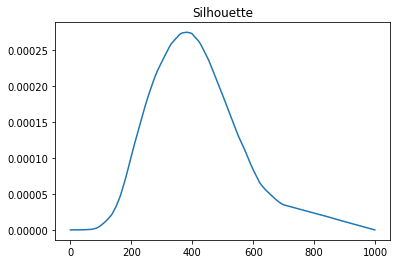

In [10]:
plt.plot(sh[0])
plt.title("Silhouette")

The second method is the [persistence image](http://jmlr.org/papers/v18/16-337.html). A persistence image is obtained by rotating by $-\pi/4$, centering Gaussian functions on all diagram points (usually weighted by a parameter function---here we consider the squared distance to the diagonal) and summing all these Gaussians. This gives a 2D function, that is pixelized into an image.

In [11]:
PI = gd.representations.PersistenceImage(bandwidth=1e-4, weight=lambda x: x[1]**2, \
                                         im_range=[0,.004,0,.004], resolution=[100,100])
pi = PI.fit_transform([acX.persistence_intervals_in_dimension(1)])

Text(0.5, 1.0, 'Persistence Image')

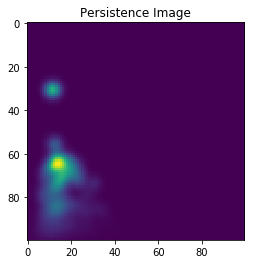

In [12]:
plt.imshow(np.flip(np.reshape(pi[0], [100,100]), 0))
plt.title("Persistence Image")

Neat, right? Gudhi also contains implementations of less common vectorization methods, such as the [Betti curve](https://www.researchgate.net/publication/316604237_Time_Series_Classification_via_Topological_Data_Analysis), the [complex polynomial]( https://link.springer.com/chapter/10.1007%2F978-3-319-23231-7_27), or the [topological vector](https://diglib.eg.org/handle/10.1111/cgf12692). You can check the [representations](https://gudhi.inria.fr/python/3.1.0.rc1/representations.html) module to check everything that is available.

Gudhi also contain implementations of various kernels, i.e., scalar products for persistence diagrams. More precisely a kernel is a function $k$ that takes a pair of diagrams as inputs and outputs a real value such that:
$$k(D,D')=\langle \Phi(D), \Phi(D')\rangle_{\mathcal{H}},$$
for some implicit Hilbert space $\mathcal{H}$ and continuous function $\Phi:\mathcal{D}\rightarrow\mathcal{H}$. Many algorithms, such as SVM or PCA, only require pairwise scalar products to be able to run on data. With Gudhi, you can compute the [persistence scale space kernel](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Reininghaus_A_Stable_Multi-Scale_2015_CVPR_paper.pdf), [persistence weighted Gaussian kernel](http://proceedings.mlr.press/v48/kusano16.html), [persistence Fisher kernel](https://papers.nips.cc/paper/8205-persistence-fisher-kernel-a-riemannian-manifold-kernel-for-persistence-diagrams) and [sliced Wasserstein kernel]( http://proceedings.mlr.press/v70/carriere17a.html). Of course, you can also directly compute the bottleneck and Wasserstein distances ;-)

In order to test these functions, we need a second point cloud and corresponding persistence diagram. Let's pick another $r$.

In [4]:
r = 4.1
Y = np.empty([num_pts,2])
x, y = np.random.uniform(), np.random.uniform()
for i in range(num_pts):
    Y[i,:] = [x, y]
    x = (Y[i,0] + r * Y[i,1] * (1-Y[i,1])) % 1.
    y = (Y[i,1] + r * x * (1-x)) % 1.

In [14]:
acY = gd.AlphaComplex(points=Y).create_simplex_tree()
dgmY = acY.persistence()

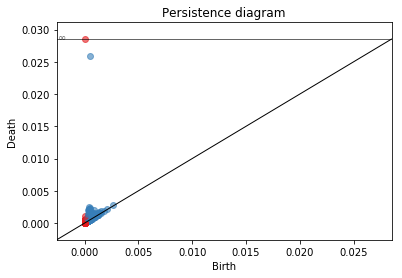

In [15]:
gd.plot_persistence_diagram(dgmY)

Looks like this one has interesting homology! Let's plot it.

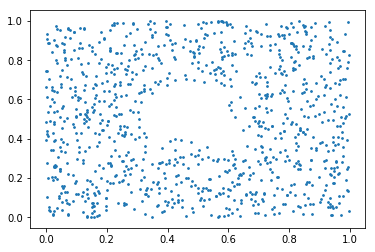

In [5]:
plt.scatter(Y[:,0], Y[:,1], s=3)
plt.show()

Indeed, there is a hole in the middle now for some reasons...

Let's now check all pairwise kernels and metrics!

In [16]:
PWG = gd.representations.PersistenceWeightedGaussianKernel(bandwidth=0.01, kernel_approx=None,\
                                        weight=lambda x: np.arctan(np.power(x[1], 1)))
PWG.fit([acX.persistence_intervals_in_dimension(1)])
pwg = PWG.transform([acY.persistence_intervals_in_dimension(1)])
print("PWG kernel is " + str(pwg[0][0]))

PSS = gd.representations.PersistenceScaleSpaceKernel(bandwidth=1.)
PSS.fit([acX.persistence_intervals_in_dimension(1)])
pss = PSS.transform([acY.persistence_intervals_in_dimension(1)])
print("PSS kernel is " + str(pss[0][0]))

PF = gd.representations.PersistenceFisherKernel(bandwidth_fisher=.001, bandwidth=.001, kernel_approx=None)
PF.fit([acX.persistence_intervals_in_dimension(1)])
pf = PF.transform([acY.persistence_intervals_in_dimension(1)])
print("PF kernel is " + str(pf[0][0]))

SW = gd.representations.SlicedWassersteinKernel(bandwidth=.1, num_directions=100)
SW.fit([acX.persistence_intervals_in_dimension(1)])
sw = SW.transform([acY.persistence_intervals_in_dimension(1)])
print("SW kernel is " + str(sw[0][0]))

BD = gd.representations.BottleneckDistance(epsilon=.001)
BD.fit([acX.persistence_intervals_in_dimension(1)])
bd = BD.transform([acY.persistence_intervals_in_dimension(1)])
print("Bottleneck distance is " + str(bd[0][0]))

WD = gd.representations.WassersteinDistance(internal_p=2, order=2)
WD.fit([acX.persistence_intervals_in_dimension(1)])
wd = WD.transform([acY.persistence_intervals_in_dimension(1)])
print("Wasserstein distance is " + str(wd[0][0]))

PWG kernel is 12.368203536113965
PSS kernel is 0.005030895688591386
PF kernel is 0.44037297937754905
SW kernel is 0.7880720371858232
Bottleneck distance is 0.013070859973065046
Wasserstein distance is 0.01815319639046967


Cool! However, you have probably noticed that there are quite a lot of parameters to choose. In practice, it is better to cross-validate among a bunch of them and pick the best ones. We will see shortly that it is actually very easy to do this with Gudhi!

Now let's generate a complete dataset. We will generate point clouds and corresponding persistence diagrams for various radii $r$. Of course, you can increase the size of the dataset by modifying the num_diag_per_class variable.

In [17]:
num_diag_per_class = 10

dgms, labs = [], []
for idx, radius in enumerate([2.5, 3.5, 4., 4.1, 4.3]):
    for _ in range(num_diag_per_class):
        labs.append(idx)
        X = np.empty([num_pts,2])
        x, y = np.random.uniform(), np.random.uniform()
        for i in range(num_pts):
            X[i,:] = [x, y]
            x = (X[i,0] + radius * X[i,1] * (1-X[i,1])) % 1.
            y = (X[i,1] + radius * x * (1-x)) % 1.
        ac = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=1e12)
        dgm = ac.persistence()
        dgms.append(ac.persistence_intervals_in_dimension(1))

Then, we shuffle the data and create a 80/20 split for train and test.

In [18]:
test_size            = 0.2
perm                 = np.random.permutation(len(labs))
limit                = np.int(test_size * len(labs))
test_sub, train_sub  = perm[:limit], perm[limit:]
train_labs           = np.array(labs)[train_sub]
test_labs            = np.array(labs)[test_sub]
train_dgms           = [dgms[i] for i in train_sub]
test_dgms            = [dgms[i] for i in test_sub]

In order to cross-validate among all methods and parameters available, we create a scikit-learn pipeline for processing the diagrams. The pipeline will:
1. extract the points of the persistence diagrams with finite coordinates (i.e. the non essential points)
2. scale or not the diagrams in the unit square
3. handle diagrams with vectorization or kernel methods with Gudhi
4. train a classifier from the scikit-learn package

As you can see from the code below, it is quite simple! Here, we cross validate among a kernel-SVM with sliced Wasserstein and persistence weighted Gaussian kernels, C-SVM on persistence images, random forests on landscapes, and $k$-nearest neighbors on bottleneck distances. We also try uniformly scaling the diagrams to the unit square.

In [19]:
from sklearn.preprocessing   import MinMaxScaler
from sklearn.pipeline        import Pipeline
from sklearn.svm             import SVC
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier

# Definition of pipeline
pipe = Pipeline([("Separator", gd.representations.DiagramSelector(limit=np.inf, point_type="finite")),
                 ("Scaler",    gd.representations.DiagramScaler(scalers=[([0,1], MinMaxScaler())])),
                 ("TDA",       gd.representations.PersistenceImage()),
                 ("Estimator", SVC())])

# Parameters of pipeline. This is the place where you specify the methods you want to use to handle diagrams
param =    [{"Scaler__use":         [False],
             "TDA":                 [gd.representations.SlicedWassersteinKernel()], 
             "TDA__bandwidth":      [0.1, 1.0],
             "TDA__num_directions": [20],
             "Estimator":           [SVC(kernel="precomputed", gamma="auto")]},
            
            {"Scaler__use":         [False],
             "TDA":                 [gd.representations.PersistenceWeightedGaussianKernel()], 
             "TDA__bandwidth":      [0.1, 0.01],
             "TDA__weight":         [lambda x: np.arctan(x[1]-x[0])], 
             "Estimator":           [SVC(kernel="precomputed", gamma="auto")]},
            
            {"Scaler__use":         [True],
             "TDA":                 [gd.representations.PersistenceImage()], 
             "TDA__resolution":     [ [5,5], [6,6] ],
             "TDA__bandwidth":      [0.01, 0.1, 1.0, 10.0],
             "Estimator":           [SVC()]},
            
            {"Scaler__use":         [True],
             "TDA":                 [gd.representations.Landscape()], 
             "TDA__resolution":     [100],
             "Estimator":           [RandomForestClassifier()]},
           
            {"Scaler__use":         [False],
             "TDA":                 [gd.representations.BottleneckDistance()], 
             "TDA__epsilon":        [0.1], 
             "Estimator":           [KNeighborsClassifier(metric="precomputed")]}
           ]

Our final model is the best estimator found after 3-fold cross-validation of our pipeline.

In [20]:
from sklearn.model_selection import GridSearchCV

model = GridSearchCV(pipe, param, cv=3)

Now is time to train the model. Since we perform cross-validation, the computation can be quite long, especially if using k-NN with bottleneck distances, which is quite time-consuming. You may consider grabbing a cup of coffee at this point.

In [ ]:
model = model.fit(train_dgms, train_labs)

Training is finally over! Let us check what is the best method for persistence diagrams with respect to this classification problem.

In [22]:
print(model.best_params_)

{'Estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), 'Scaler__use': True, 'TDA': Landscape(num_landscapes=5, resolution=100, sample_range=array([0., 1.])), 'TDA__resolution': 100}


Looks like random forests and landscapes did the best for this small dataset! Let's see our model accuracy on the test set.

In [23]:
print("Train accuracy = " + str(model.score(train_dgms, train_labs)))
print("Test accuracy  = " + str(model.score(test_dgms,  test_labs)))

Train accuracy = 0.975
Test accuracy  = 0.7


70%, not so bad for such a small dataset! The accuracy you get can even improve for bigger datasets and more parameters in the cross-validation (but training time will increase as well ;-)). 